<a href="https://colab.research.google.com/github/bmf87/ml-ds-projects/blob/main/ds552/week2_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS 552 - Generative AI
* Assignment 2: Logistic Regression vs Naive Bayes
* Datasets: Palmer Penguin and MNIST
* Author: Brett Favro

**Objective:** Evaluate the performance of generative models (Naive Bayes) and discriminative models (Logistic Regression) on simple to more complex datasets.

# Performance: Simple Dataset
* Palmer Penguin dataset - 344 observations of penguins from three species collected from the Palmer Archipelago in Antarctica.
  * Includes 8 key variables: species, island, bill length/depth, flipper length, body mass, sex, and year.

## Install and Load Libraries

In [1]:
!pip install -q palmerpenguins
from palmerpenguins import load_penguins

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

### Custom reusable utilities

In [3]:
!git clone https://github.com/bmf87/ml.git
from ml.utils import dataprep_utils as du

Cloning into 'ml'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 6), reused 18 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 6.85 KiB | 6.85 MiB/s, done.
Resolving deltas: 100% (6/6), done.


## Data Load and EDA
- Using the [Palmer Penguin](https://archive.ics.uci.edu/dataset/690/palmer+penguins-3) open dataset
- ML models will use two species: Adelie and Gentoo for binary classification

In [14]:
penguins_df = load_penguins()
penguins_df.shape
#penguins_df.describe() # descriptive statistics (numerics only)

(344, 8)

In [5]:
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


In [6]:
eda_df = du.missing_values_table(penguins_df)
eda_df


          Dataframe Summary:
            - Total Columns: 8
            - Total Rows: 344
            - Total Rows with missing values: 11
            - Total Columns with missing values: 5
          
        


,Missing Values,% of Total Values
sex,11,3.2
bill_length_mm,2,0.6
bill_depth_mm,2,0.6
flipper_length_mm,2,0.6
body_mass_g,2,0.6


### Missing Values
- Remove missing values in the dataframe. There are very few.
- Alternative solutions *would* be to impute values with something like sklearn.impute.SimpleImputer

In [7]:
penguins_df = penguins_df.dropna() # remove 11 rows
penguins_df.reset_index(drop=True, inplace=True) # reindex post drop
penguins_df.shape

(333, 8)

In [8]:
penguins_df['species'].value_counts()

,count
species,
Adelie,146
Gentoo,119
Chinstrap,68


### Binary Classification
- Subset to Adelie and Gentoo species only
- Make Gentoo the positive class

In [16]:
penguins_subset = penguins_df.loc[penguins_df['species'].isin(['Adelie', 'Gentoo'])]
penguins_subset['species_encoded'] = np.where(penguins_subset['species']=='Adelie', 0, 1)
penguins_subset.drop(columns=['year'], inplace=True)
penguins_subset.head(5)

/tmp/ipython-input-1884498448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins_subset['species_encoded'] = np.where(penguins_subset['species']=='Adelie', 0, 1)
/tmp/ipython-input-1884498448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins_subset.drop(columns=['year'], inplace=True)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,species_encoded
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,0
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,0


### Pearsons: Strength & Direction of Relationships (range: -1..1)
Pearson's Correlation Coefficient (PCC) measures the strength and direction of a linear relationship between two variables, X<sub>1</sub> and X<sub>2</sub>

- +1 indicates positive correlation
- -1 indicates negative correlation
- 0 no linear correlation
- Observed ***Strong Positive Correlations***
  1. Body mass and flipper length
  2. Body mass and bill length
  3. Flipper length and bill length
  4. Bill and flipper length and species_encoded (target variable)
- Observed ***Strong Negative Correlations***
  1. Flipper length and bill depth

In [10]:
# Run1:
#penguins_final = penguins_subset[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
# Run2: Removed 'flipper_length_mm' due to VIF
penguins_final = penguins_subset[['bill_length_mm', 'bill_depth_mm', 'body_mass_g']]
# pairwise correlation
corr_matrix = penguins_final.corr(numeric_only=True)
corr_matrix

,bill_length_mm,bill_depth_mm,body_mass_g
bill_length_mm,1.000000,-0.543166,0.876786
bill_depth_mm,-0.543166,1.000000,-0.483227
body_mass_g,0.876786,-0.483227,1.000000


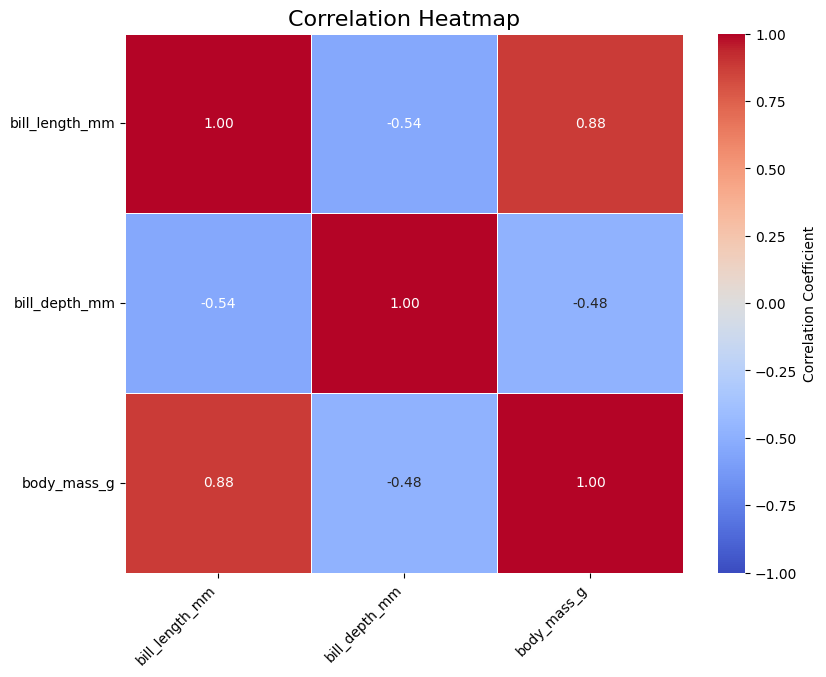

In [11]:
plt.figure(figsize=(9, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,       # Small gaps between cells
    cbar_kws={'label': 'Correlation Coefficient'},
    vmin=-1, vmax=1,     # Ensure color scale spans from -1 to 1
    center=0             # Center the colormap at zero
)

plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.show()

### VIF: Variance Inflation Factor
VIF measures how much a predictor's variance is inflated due to its correlation with other predictors or independent variables. It is multivariate, unlike Pearsons, which is pairwise.
* 1-5: moderate multicollinearity
* \>5: high multicollinearity
* \>10: serious multicollinearity
* Initial run showed $\color{red}{\text{high multicollinearity}}$ for:
  * bill_length_mm: 5.306188
  * flipper_length_mm: **6.975372**
  * body_mass_g: 6.198186
* **Action Taken:** Removed flipper_length_mm




In [12]:
pf_copy = penguins_final.copy()
# Add constant (intercept term)
pf_copy = add_constant(pf_copy)

# Calculate VIF for features
pf_vif = pd.DataFrame()
pf_vif['Feature'] = pf_copy.columns
pf_vif['VIF'] = [variance_inflation_factor(pf_copy.values, i) for i in range(pf_copy.shape[1])]
pf_vif

,Feature,VIF
0,const,318.731668
1,bill_length_mm,4.703192
2,bill_depth_mm,1.418923
3,body_mass_g,4.325702


### Body Mass & Flipper Length
- Visual of the Positive Relationship between Body Mass and Bill Length
- Positive class (Gentoo) has some overlap but fair amount of separation
- Overall, Adelie and Gentoo (quite larger) separate quite well, making this a rather trivial binary classification problem

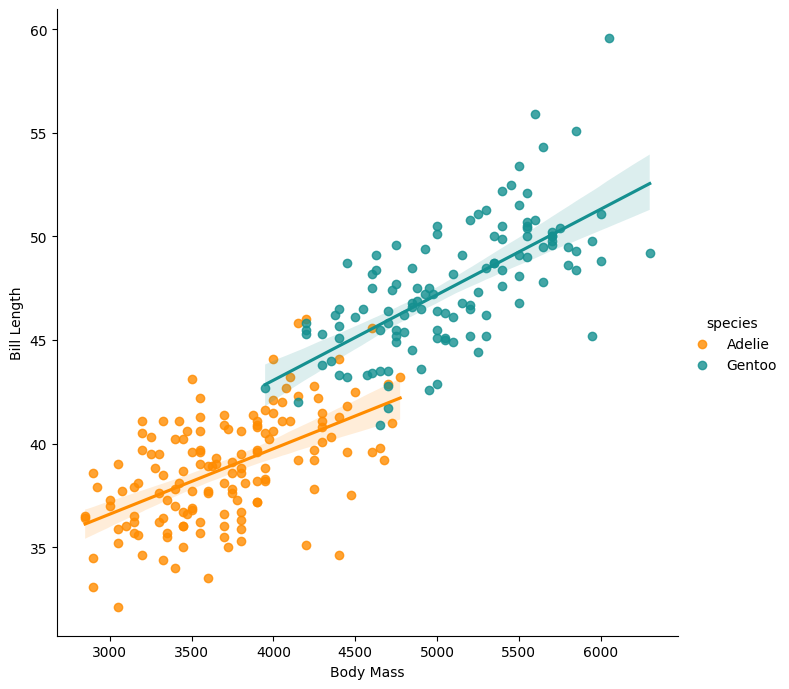

In [13]:
g = sns.lmplot(x="body_mass_g",
               y="bill_length_mm",
               hue="species",
               height=7,
               data=penguins_subset,
               palette=['#FF8C00','#159090','#A034F0'])

g.set_xlabels('Body Mass')
g.set_ylabels('Bill Length')

In [14]:
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

## Feature Transformation
- Both models require numeric data. Feature selection will include continuous numeric data from the penguin's physical characteristics
- Features transformed using [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html). This makes the data more Gaussian-like (stabilizes variance). This includes standardization (z-score normalized) to prevent features with large values from dominating
  - Ensures large values don't disproportional affect model
  - Aligns features closer to normal distribution (mean=0, std=1)

In [15]:
#sex_le = LabelEncoder()
#penguins_final['sex_encoded'] = sex_le.fit_transform(penguins_final['sex'])
# one-hot encode island feature
#penguins_final = pd.get_dummies(penguins_final, columns=['island'], prefix='island', dtype=int)
#penguins_final.head(5)

### Notebook Functions

In [17]:
classes = penguins_subset.groupby('species')['species_encoded'].unique()
print(classes) # Gentoo is the positive case

def analyze_distributions(df):
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    axes = axes.flatten()

    for i, col in enumerate(df):
      sns.histplot(df[col], kde=True, bins=15, ax=axes[i], color='skyblue', edgecolor='black') # Add KDE for smoothness
      axes[i].set_title(f'Distribution of {col}', fontweight='bold')
      axes[i].set_xlabel('Value')
      axes[i].set_ylabel('Density' if sns.histplot.__kwdefaults__.get('stat') == 'density' else 'Count') # Adjust label based on stat parameter
      sns.despine(ax=axes[i], top=True, right=True) # Remove top and right borders

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, labels):
    y_pred = model.predict(X_test)
    results_df = pd.DataFrame(columns=['precision', 'recall', 'f1_score'])
    # Get accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Get precision, recall, f1
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
    results_df['precision'] = precision
    results_df['recall'] = recall
    results_df['f1_score'] = fscore
    results_df['support'] = support
    # Get class labels
    results_df['species'] = labels
    # Make 'species' first column
    cols = ['species'] + [col for col in results_df.columns if col != 'species']
    results_df = results_df[cols]
    return y_pred, accuracy, results_df

def generate_roc_curve(y_proba_lr, y_proba_gnb, y, labels, dataset):
    proba_df = pd.DataFrame(
        {'True': y, 'LogisticRegression': y_proba_lr, 'GaussianNB': y_proba_gnb})

    plt.figure(figsize=(7, 5))
    ctr=0
    for model in ['LogisticRegression', 'GaussianNB']:
      print(f'Generating ROC Curve for {model}')
      fpr, tpr, thresholds = roc_curve(proba_df['True'], proba_df[model])
      roc_auc = auc(fpr, tpr)
      print(f'{ctr}]fpr and tpr for {model}: TPR {tpr} FPR {fpr}')
      plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')
      ctr+=1

    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset}')
    plt.legend()
    plt.show()

species
Adelie    [0]
Gentoo    [1]
Name: species_encoded, dtype: object


### ML Models: An Overview
- [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) - assumes data follows normal/Gaussian distribution.
  - Requires features to be numeric continuous. *Could* use CategoricalNB on categorical features and then combine results.
  - *Naive* assumption of conditional feature independence. If features X<sub>i</sub> and X<sub>j</sub> are highly correlated (multicollinear), indepedence breaks down, leading to inaccurate probability estimates
  - Performs well with small datasets

- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) - used for binary classification. Uses sigmoid function to covert into a probability value between 0..1
  - Requires inputs to be numeric. Can handle binary categorical and multiclass categorical via encoding, OHE or label encoding (binary)
  - Requires no severe multicollinearity among features/independent variables
  - Observations are independent - plot of residuals should be random pattern
  - No extreme outliers in the dataset


In [17]:
# Define features (X) and target (y) for model training
X = penguins_subset[['bill_length_mm', 'bill_depth_mm', 'body_mass_g']]
y = penguins_subset['species_encoded']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [19]:
print(f'''
Ensure Balanced Train/Test datasets:

  - Train: {y_train.value_counts()}

  - Test: {y_test.value_counts()}
''')


Ensure Balanced Train/Test datasets:

  - Train: species_encoded
0    102
1     83
Name: count, dtype: int64

  - Test: species_encoded
0    44
1    36
Name: count, dtype: int64



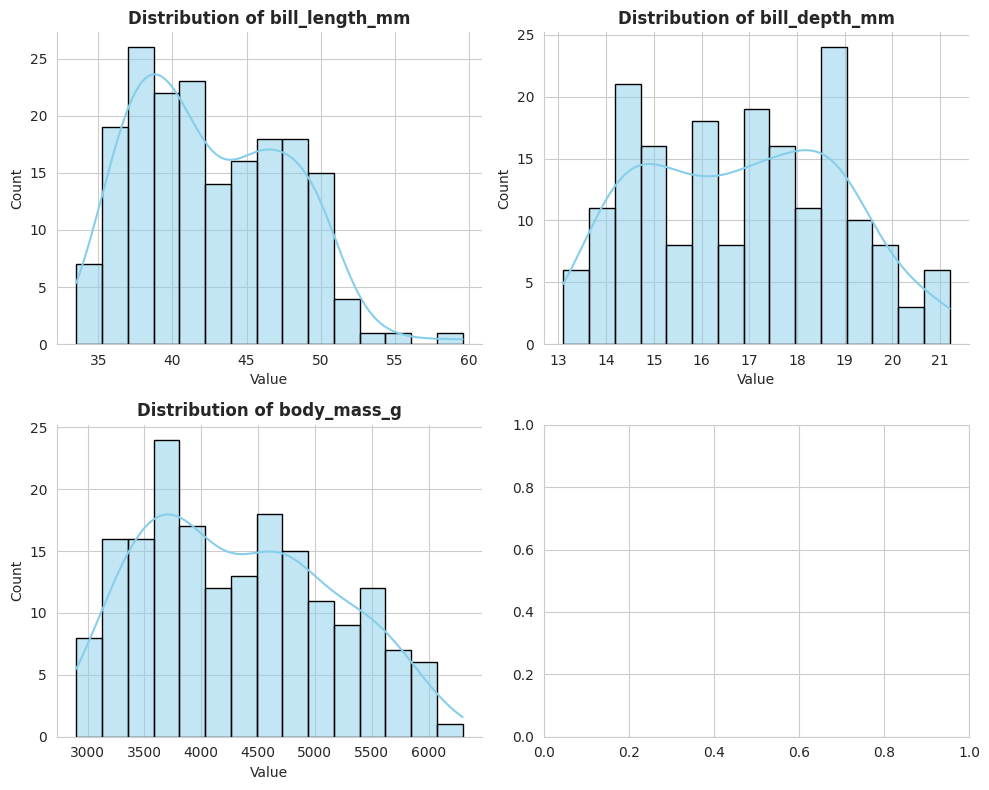

In [20]:
analyze_distributions(X_train)

In [21]:
pt = PowerTransformer(standardize=True) # Perform Standard Scaling
X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

### Post PowerTransformer: Scaled & More Gaussian-Like

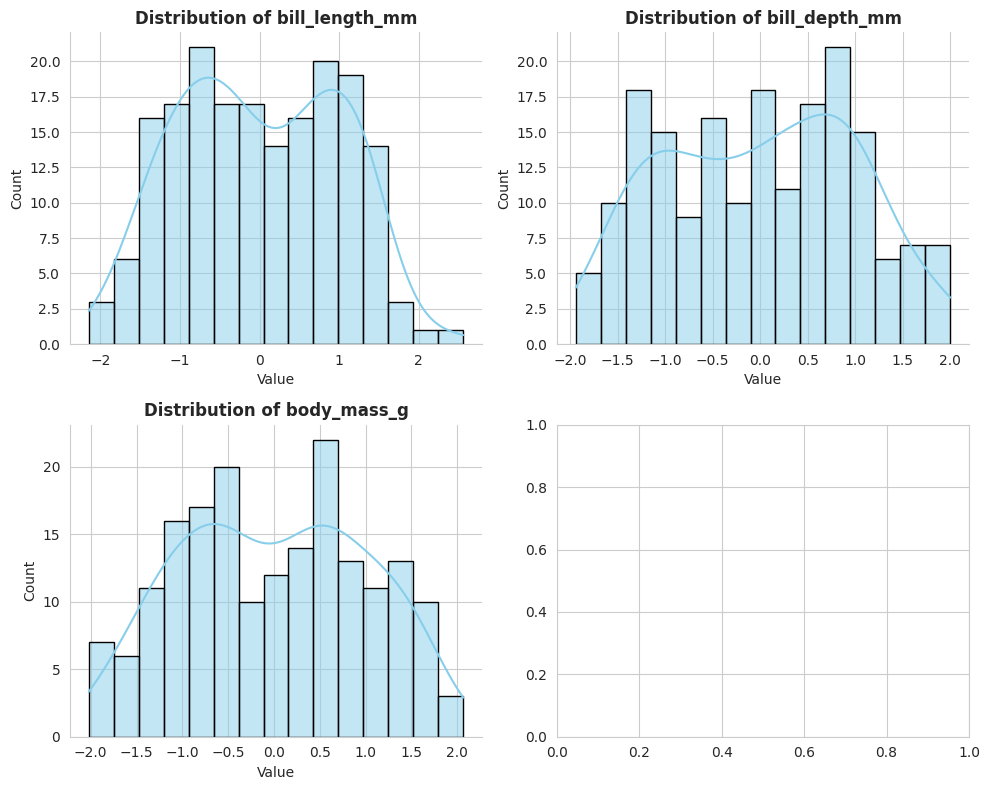

In [22]:
analyze_distributions(pd.DataFrame(X_train_transformed, columns=X_train.columns))

## Model Training

### Train Naive Bayes Model
* Perform 5-fold CV to reduce bias from any split
* Use Regularization to improve generalization by:
  * Smooth Probabilities
  * Prevent memorizing training specifics (overfitting)

In [23]:
gnb_model = GaussianNB()
# spaced sample: 10^0..10^-9
params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}

# GridSearchCV: 5-fold CV
gs_gnb = GridSearchCV(estimator=gnb_model,
                     param_grid=params_NB,
                     cv=5,
                     verbose=1,
                     scoring='accuracy',
                     return_train_score=True)

gs_gnb.fit(X_train_transformed, y_train)

# Display best parameter and score
print(f"Best parameters: {gs_gnb.best_params_}")
print("Cross-validation scores:", gs_gnb.cv_results_.get('mean_test_score'))
print(f"Best cross-validation score: {gs_gnb.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'var_smoothing': np.float64(1.0)}
Cross-validation scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Best cross-validation score: 1.0


#### Predict and Evaluate
* Visual analyses shows clear separation/disjoint clusters by species using bill length and body mass
* **[Accuracy Comparison]:** ***GaussianNB*** assumes class conditional normality in each feature with non-overlapping distributions. The Palmer Penguin data is clearly separable by species. This led to error-free classifications on all cross-validation folds during training.
* GaussianNB model performance was perfect on the test set.

In [24]:
# Predict on test/unseen data
gnb_y_pred, accuray, gnb_results_df = evaluate_model(gs_gnb.best_estimator_,
                                                     X_test_transformed,
                                                     y_test,
                                                     classes.index)
print(f'''[GaussianNB Test Results]
Accuracy: {accuray:.2f}
''')
gnb_results_df



[GaussianNB Test Results]
Accuracy: 1.00



,species,precision,recall,f1_score,support
0,Adelie,1.0,1.0,1.0,44
1,Gentoo,1.0,1.0,1.0,36


### Train Logistic Regression Model
* **[Accuray Comparison]:** ***LogisticRegression*** assumes that the log-odds are a linear combination of the features. Any slight nonlinearity or local overlap can lead to missclassification of edge points.
* While the model performed well overall with the test set, its average performance score on some hold-out validation folds were as low as 49%.

In [25]:
import warnings

# hyperparameter grid: 180 combinations
params_LR = {
    'C': np.logspace(-4, 4, 20),           # C: inverse of regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'], # Test L1, L2, and Elastic-Net penalties
    'l1_ratio': [0, 0.5, 1]                # l1_ratio is only for elasticnet (0=L2, 1=L1)
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_model = LogisticRegression(max_iter=1000, solver='saga') # saga supports all penalties
    gs_lr = GridSearchCV(estimator=lr_model,
                        param_grid=params_LR,
                        cv=5,
                        scoring='accuracy',
                        return_train_score=True,
                        verbose=1)

    gs_lr.fit(X_train_transformed, y_train)

# Display best parameters and score
print("Best parameters:", gs_lr.best_params_)
print("Cross-validation scores:", gs_lr.cv_results_.get('mean_test_score'))
print("Best cross-validation score:", gs_lr.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'C': np.float64(0.004832930238571752), 'l1_ratio': 0, 'penalty': 'l2'}
Cross-validation scores: [0.50810811 0.55135135 0.55135135 0.50810811 0.55135135 0.55135135
 0.52432432 0.55135135 0.53513514 0.53513514 0.55135135 0.55135135
 0.51891892 0.55135135 0.55135135 0.52432432 0.55135135 0.53513514
 0.53513514 0.55135135 0.55135135 0.51891892 0.55135135 0.55135135
 0.55135135 0.55135135 0.55135135 0.55135135 0.90810811 0.90810811
 0.4972973  0.90810811 0.55135135 0.53513514 0.90810811 0.55135135
 0.52432432 1.         1.         0.53513514 1.         0.55135135
 0.55135135 1.         0.55135135 0.55135135 1.         1.
 0.55135135 1.         0.99459459 0.55135135 1.         0.55135135
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.    

#### Predict and Evaluate
* LinearRegression imposes linear decision boundaries

In [26]:
# Predict on test set
lr_y_pred, accuracy, lr_results_df = evaluate_model(gs_lr.best_estimator_,
                                                    X_test_transformed,
                                                    y_test,
                                                    classes.index)
print(f'''[LogisticRegression Test Results]
Accuracy: {accuray:.2f}
''')
lr_results_df

[LogisticRegression Test Results]
Accuracy: 1.00



,species,precision,recall,f1_score,support
0,Adelie,1.0,1.0,1.0,44
1,Gentoo,1.0,1.0,1.0,36


## AUC-ROC Curves
- AUC-ROC curve helps determine how well a binary classification model performs
  - High AUC - close to 1
  - Low AUC - close to 0
  - AUC ~0.5 - model does not learn any meaningful patterns
- True Positive Rate (TPR) - model correctly predicts the positive case
- False Positsive Rate (FPR) - model incorrectly predicts the negative case as positive

Generating ROC Curve for LogisticRegression
0]fpr and tpr for LogisticRegression: TPR [0.         0.02777778 1.         1.        ] FPR [0. 0. 0. 1.]
Generating ROC Curve for GaussianNB
1]fpr and tpr for GaussianNB: TPR [0.         0.02777778 1.         1.        ] FPR [0. 0. 0. 1.]


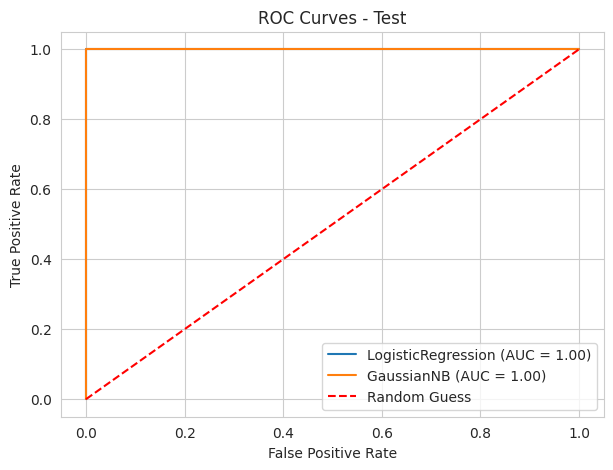

In [27]:
# ROC curve requires probability estimates for positive class (class 1)
y_proba_gnb = gs_gnb.best_estimator_.predict_proba(X_test_transformed)[:, 1]
y_proba_lr = gs_lr.best_estimator_.predict_proba(X_test_transformed)[:, 1]

generate_roc_curve(y_proba_lr, y_proba_gnb, y_test, classes.index, "Test")

Generating ROC Curve for LogisticRegression
0]fpr and tpr for LogisticRegression: TPR [0.         0.01204819 1.         1.        ] FPR [0. 0. 0. 1.]
Generating ROC Curve for GaussianNB
1]fpr and tpr for GaussianNB: TPR [0.         0.01204819 1.         1.        ] FPR [0. 0. 0. 1.]


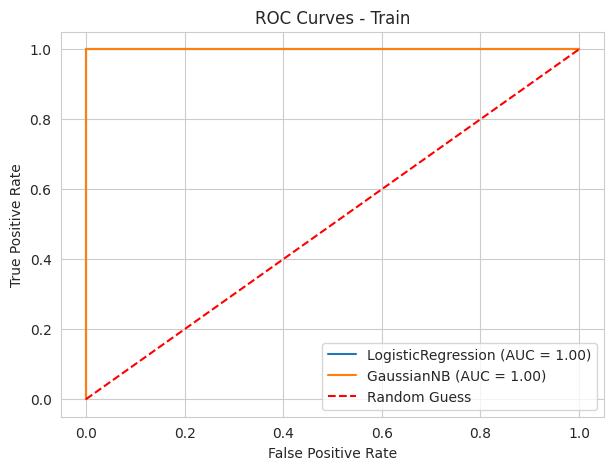

In [28]:
y_proba_gnb = gs_gnb.best_estimator_.predict_proba(X_train_transformed)[:, 1]
y_proba_lr = gs_lr.best_estimator_.predict_proba(X_train_transformed)[:, 1]

generate_roc_curve(y_proba_lr, y_proba_gnb, y_train, classes.index, "Train")

### AUC Evaluation

**[Area Under the Curve (AUC) Evaluation]:** AUC measures ranking, not exact probabilities. AUC reflects how well a model ranks the positive class above the negative class, across all thresholds, not how well it calibrates probabilities. That is where we observed some differences on certain CV folds. *See the cross-validation scores above*. In other words, AUC shows how a binary classifier TPR trades off against FPR as you vary the classification threshold. **Overall Result:** Both models ranked Gentoo (positive class) vs Adelie almost identically well across thresholds proving their ability to identify TPR very well.

Both models are inducing similar decision boundary P(y=1 | x) under main assumptions, e.g. features close to normally distributed within classes, linearity in parameters, and limited multicollinearity (~feature independence). As noted previously, these two classes (penguin species) are cleanly seperable, irrespective of the three chosen features here, leading to equivalent performance measured by AUC.



## Lift and Gain Charts
Lift and Gain charts translate model performance into expected payoff curves. They evaluate performance in a portion of the population. These charts use decile analysis. Lift and Gain charts are used in binary classification to answer a business-oriented question like which model provides more positives in say the top 20% band, or which is more profitable at a given budget level?



In [36]:
!pip install -q scikit-plot

In [47]:
# Note: required manual changes for scikitplot ;(
# python3.12/dist-packages/scikitplot/ (1) metrics.py and (2) plotters.py
# Changed import to => from numpy import interp
import scikitplot as skplt

def gain_lift_chart(y_test, y_proba, subtitle):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # Cumulative Gain Chart
    skplt.metrics.plot_cumulative_gain(y_test, y_proba, ax=axes[0])
    axes[0].set_title(f'Cumulative Gains Chart - {subtitle}')
    # Lift Curve
    skplt.metrics.plot_lift_curve(y_test, y_proba, ax=axes[1])
    axes[1].set_title(f'Lift Chart- {subtitle}')

    plt.tight_layout()
    plt.show()


In [48]:
y_gnb_proba = gs_gnb.best_estimator_.predict_proba(X_test_transformed)
y_lr_proba = gs_lr.best_estimator_.predict_proba(X_test_transformed)

### GaussianNB: Gain and Lift Chart

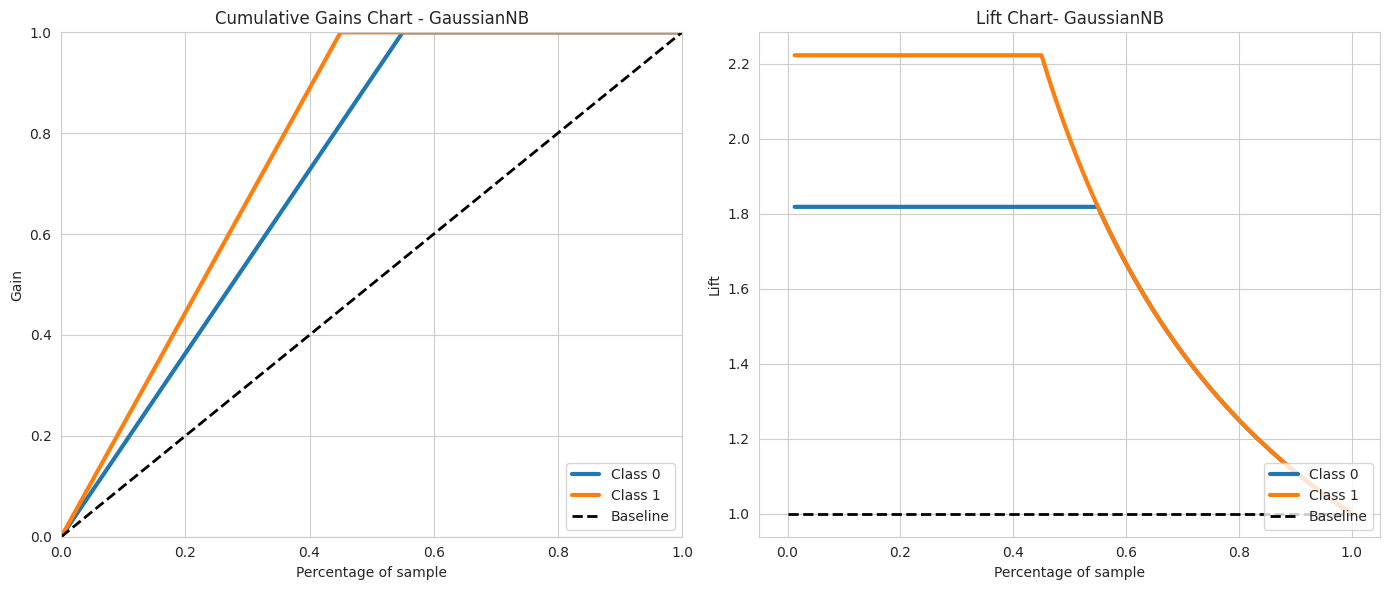

In [49]:
gain_lift_chart(y_test, y_gnb_proba, "GaussianNB")

### LogisticRegression: Gain and Lift Chart

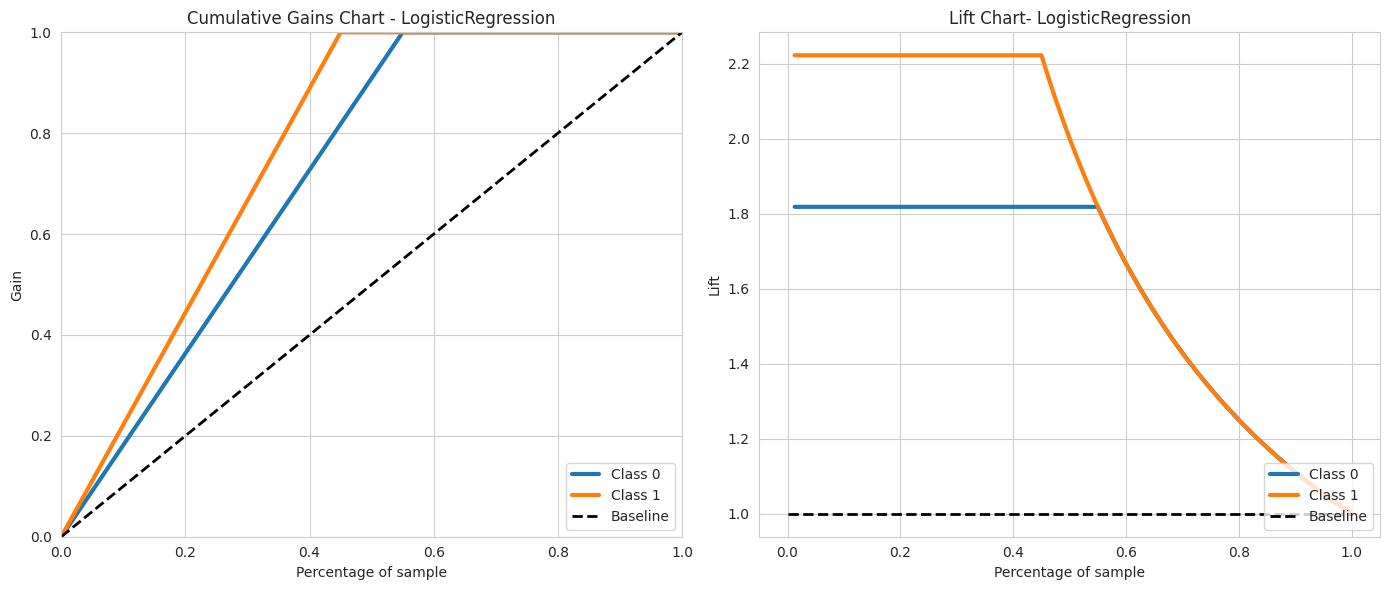

In [50]:
gain_lift_chart(y_test, y_lr_proba, "LogisticRegression")

### Gain and Lift Evaluation
**[Gain Chart Evaluation]:** The Gain charts for both models are identical, showing a very steep curve.

Gain Results indicate:
1. That at 20% (2nd decile), you can obtain about 45% of positives.
2. At 40% of the data, you can obtain about 90% of positives.
3. In comparison, random/baseline would require 90% of the data to get 90% positives.

**[Lift  Chart Evaluation]:** The Lift charts for both models are identical.

Lift Results indicate:
1. Up to ~45% (4th decile), the models are 2.2 times better than random/baseline.
3. At 80%, the models are still 1.2 times better than random/baseline.


## Overall Model Performance

Both models performed exceptionally well on this simple binary classification problem. Since both models reach 1.0 accuracy on the test data, AUC=1.0, and have identical Gain and Lift charts, one should consider more than performance metrics alone to separate them.

Considering the different CV scores, LogisticRegression had some folds that were low, as low as 0.49 (worst). This *could* be due to higher variance across the folds. Potentially this is due to the smaller Palmer Penguin dataset size, which created small sample sizes per fold. LR requires larger datasets than GaussianNB.

GaussianNB is simple and efficient with fewer tunable parameters, but requires feature independence. LogisticRegression's coefficients translate directly into log-odds ratios, which can be easier to explain to stakeholders, and it can degrade more gracefully. It does not break if the feature independence assumption becomes violated, like GaussianNB.

**Result:** I give a slight performance advantage to GaussianNB based on the overall performance observed, but if the solution were to be deployed to production to make real world decisions, I would choose LogisticRegression. It would scale better when/if the data became noisy, be easier to explain how it works (results) to stakeholders (XAI), and has more tunable hyperparameters to optimize.


# Performance: Complex Dataset
* MNIST dataset - features 70K grayscale pixel images (28x28) of handwritten digits. Presents a multi-class problem with 10 distinct classes (0 - 9)

### Install and Load Libraries

In [41]:
from sklearn.preprocessing import label_binarize
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, roc_curve

In [28]:
# Load, split, normalize data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Normalize 8-bit grayscale to floats: 0..1
X_train_norm = X_train_raw / 255.0
X_test_norm = X_test_raw / 255.0

#type(y_train[0])
# Labels to integers
y = y.astype(int)

In [29]:
X_train_norm.shape, y_train.shape, X_test_norm.shape, y_test.shape

((56000, 784), (56000,), (14000, 784), (14000,))

## Model Training

In [48]:
def model_metrics(eval, gt_labels, y_pred):
    accuracy = accuracy_score(gt_labels, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
                                                              gt_labels,
                                                              y_pred,
                                                              average='weighted')  # Weighted for multiclass
    print(f"[{eval} Results]")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Full report for multiclass
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


def generate_roc_curves(y_proba, y_test_bin):
    # Single multiclass AUC (macro average)
    auc_macro = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='macro')
    print(f"Multiclass AUC (OvR macro): {auc_macro:.4f}")

    # Plot all 10 ROC curves
    fpr, tpr = dict(), dict()
    auc_per_class = dict()
    n_classes = y_proba.shape[1]
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
      auc_per_class[i] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {auc_per_class[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

### GaussianNB
GaussianNB fully supports multi-class classification problem by calculating the probability of each class based on the Gaussian distributions of the input features. The class with the highest probability is the select classification.

In [37]:
gnb_model = GaussianNB()
# spaced sample: 10^0..10^-9
params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}

# GridSearchCV: 5-fold CV
gs_gnb = GridSearchCV(estimator=gnb_model,
                     param_grid=params_NB,
                     cv=5,
                     verbose=1,
                     scoring='accuracy',
                     return_train_score=True)

gs_gnb.fit(X_train_norm, y_train)

# Display best parameter and score
print(f"Best parameters: {gs_gnb.best_params_}")
print("Cross-validation scores:", gs_gnb.cv_results_.get('mean_test_score'))
print(f"Best cross-validation score: {gs_gnb.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'var_smoothing': np.float64(0.0657933224657568)}
Cross-validation scores: [0.73208929 0.74251786 0.75301786 0.76223214 0.77085714 0.77839286
 0.78494643 0.79075    0.79475    0.798125   0.80010714 0.80125
 0.80180357 0.80214286 0.80126786 0.7995     0.79783929 0.79542857
 0.79305357 0.78978571 0.78633929 0.78242857 0.77839286 0.77416071
 0.77023214 0.76605357 0.76146429 0.75680357 0.75242857 0.74753571
 0.74251786 0.73780357 0.73296429 0.728375   0.72341071 0.71892857
 0.71444643 0.70964286 0.70467857 0.70008929 0.695875   0.69123214
 0.687125   0.68275    0.67866071 0.67426786 0.67046429 0.66664286
 0.66275    0.65853571 0.654625   0.65091071 0.64755357 0.64444643
 0.64105357 0.63742857 0.63419643 0.63126786 0.62828571 0.62578571
 0.62242857 0.61960714 0.61660714 0.61398214 0.61128571 0.60883929
 0.60683929 0.60435714 0.60205357 0.59998214 0.598      0.59566071
 0.59325    0.59076786 0.58858929 0.58648214

#### Predict and Evaluate

In [53]:
y_pred = gs_gnb.best_estimator_.predict(X_test_norm)
model_metrics("GaussianNB Test", y_test, y_pred)

[GaussianNB Test Results]
Accuracy: 0.8055
Precision: 0.8215
Recall: 0.8055
F1-Score: 0.8057

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1343
           1       0.78      0.96      0.86      1600
           2       0.90      0.77      0.83      1380
           3       0.82      0.77      0.79      1433
           4       0.83      0.64      0.72      1295
           5       0.89      0.64      0.75      1273
           6       0.85      0.92      0.88      1396
           7       0.94      0.81      0.87      1503
           8       0.68      0.74      0.71      1357
           9       0.61      0.87      0.72      1420

    accuracy                           0.81     14000
   macro avg       0.82      0.80      0.80     14000
weighted avg       0.82      0.81      0.81     14000



Multiclass AUC (OvR macro): 0.9724


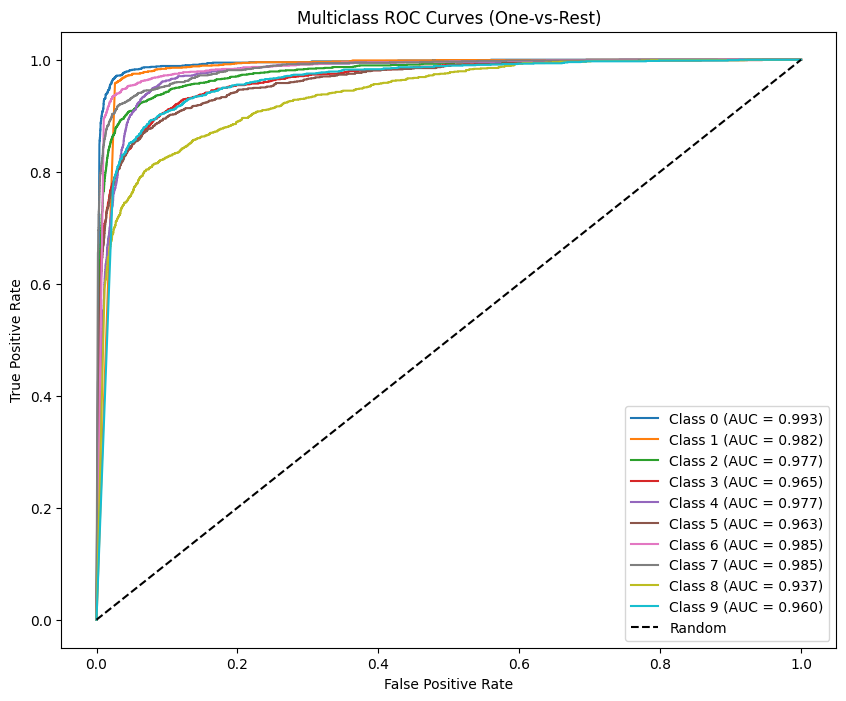

In [54]:
# Get predictions
gnb_y_proba = gs_gnb.best_estimator_.predict_proba(X_test_norm)  # Shape: (n_test, 10)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))  # Shape: (n_test, 10)
generate_roc_curves(gnb_y_proba, y_test_bin)


### LogisticRegression
LogisticRegression supports mult-class classification. The multinomial approach predicts a probability distribution across all classes. The alternative to multinomial is OvR *One-vs-Rest*. OvR splits a multi-class problem into N binary classification problem.
* Due to lengthy training/lack of convergence encountered when using multinomial, I ended up using OvR.

#### Post Normalization

* Produced results with majority of data with mean=~0 and std=0.31
* This will enable faster convergence with L1/L2 penalities.

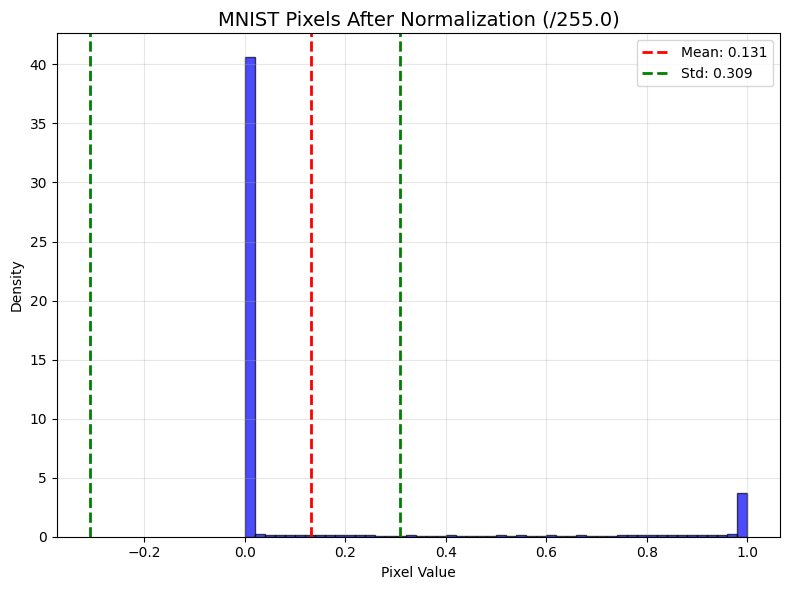

Raw:   mean=0.131, std=0.309, min=0.000, max=1.000


In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

all_pixels_norm = X_train_norm.flatten()
ax.hist(all_pixels_norm, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(all_pixels_norm.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {all_pixels_norm.mean():.3f}')
ax.axvline(all_pixels_norm.std(), color='green', linestyle='--', linewidth=2,
           label=f'Std: {all_pixels_norm.std():.3f}')
ax.axvline(-all_pixels_norm.std(), color='green', linestyle='--', linewidth=2)
ax.set_title('MNIST Pixels After Normalization (/255.0)', fontsize=14)
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary stats
print("Raw:   mean=%.3f, std=%.3f, min=%.3f, max=%.3f" %
      (all_pixels_raw.mean(), all_pixels_raw.std(), all_pixels_raw.min(), all_pixels_raw.max()))


In [55]:
 import warnings

# hyperparameter grid: 5 combinations
params_LR = {
    'C': [0.01, 0.1, 1, 10, 100],        # Sensible values
    'penalty': ['l2']                    # L2 best w/dense data
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_model = LogisticRegression(max_iter=1000,
                                  solver='lbfgs',
                                  multi_class='ovr',
                                  tol=1e-3)        # looser tolerance=quicker

    # RandomizedSearchCV samples param space faster
    rs_lr = RandomizedSearchCV(estimator=lr_model,
                        param_distributions=params_LR,
                        cv=5,
                        n_iter=10,       # find acceptable param set & control compute
                        scoring='accuracy',
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    rs_lr.fit(X_train_norm[:15000], y_train[:15000]) # subsample: limit compute

# Display best parameters and score
print("Best parameters:", rs_lr.best_params_)
print("Cross-validation scores:", rs_lr.cv_results_.get('mean_test_score'))
print("Best cross-validation score:", rs_lr.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'penalty': 'l2', 'C': 1}
Cross-validation scores: [0.89073333 0.90166667 0.90253333 0.9018     0.902     ]
Best cross-validation score: 0.9025333333333334


In [56]:
# unpack best params for full training
final_lr = LogisticRegression(**rs_lr.best_params_, max_iter=1000).fit(X_train_norm, y_train)

#### Predict and Evaluate

In [57]:
y_pred = final_lr.predict(X_test_norm)
model_metrics("LogisticRegression Test", y_test, y_pred)

[LogisticRegression Test Results]
Accuracy: 0.9204
Precision: 0.9202
Recall: 0.9204
F1-Score: 0.9202

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1343
           1       0.95      0.97      0.96      1600
           2       0.91      0.89      0.90      1380
           3       0.90      0.89      0.90      1433
           4       0.92      0.93      0.93      1295
           5       0.88      0.88      0.88      1273
           6       0.94      0.95      0.95      1396
           7       0.93      0.94      0.93      1503
           8       0.90      0.87      0.88      1357
           9       0.90      0.90      0.90      1420

    accuracy                           0.92     14000
   macro avg       0.92      0.92      0.92     14000
weighted avg       0.92      0.92      0.92     14000



Multiclass AUC (OvR macro): 0.9930


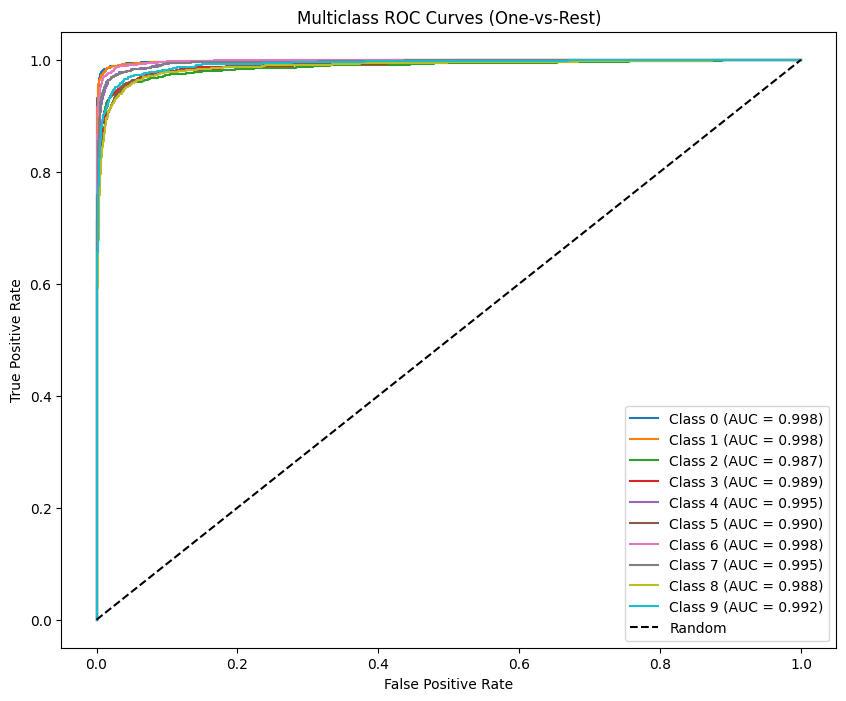

In [58]:
# Get predictions (your existing models)
lr_y_proba = final_lr.predict_proba(X_test_norm)  # Shape: (n_test, 10)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))  # Shape: (n_test, 10)
generate_roc_curves(lr_y_proba, y_test_bin)

## Final: Overall Model Performance

I did not create Lift and Gain charts for the MNIST models. This would require prioritizing a specific/*high-value* class out of the possibilities. LogisticRegression is the clear winner on the complex MNIST dataset based on all performance metrics evaluated.

&nbsp;


| Metric | LogisticRegression | GaussianNB | Winner |
|---|---|---|---|
| Accuracy | 0.92 | 0.80 | LR |
| OvR Macro AUC | 0.99 | 0.97| LR |
| Per-class AUC Range| 0.987 - 0.998 | 0.937 - 0.993 | LR |

&nbsp;

The classification report results confirm LogisticRegression's per-class precision/recall superiority. The balance of precision and recall as measured by the F1 is far superior to GaussianNB. These results were similar to accuracy, with a +12 margin to LogisticRegression (92% vs 80%).

* ## **Performance Summary**
  * **MNSIT dataset:**
    * LogisticRegression can directly learn complex decision boundaries with this sizeable dataset. It does not try to model pixels or features themselves, only the boundary that separates classes. This is what Discriminative models do.
    * GaussianNB's naive assumptions about feature independence were badly violated with all the correlated pixels in this dataset. GaussianNB tries to model each pixel independently and cannot capture shapes.

  * **Palmer Penguin dataset:**
    * Contained continuous features that were very well separated by species. After removing the flipper length feature, features were no longer highly correlated (per VIF).
    * Features used for both training and evaluating the models fit Gaussian's requirement of conditional independence per class. The features were also roughly Gaussian-shaped. This resulted in the GaussianNB model performing as well as LogisticRegression on a binary classification problem (Adelie or Gentoo).


